***

# __Utilizing Machine Learning for High Frequency Algorithmic Trading__


##### __Name:__ Masixole Boya<br>__Student number:__ 1869204

***

# __Imports__

In [1]:
from datetime import datetime
import pandas as pd
import pandas_ta as ta
import seaborn as sns
import json
from scipy.stats import linregress
# import MetaTrader5 as mt5
import mplfinance as mpf
import warnings
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import tensorflow 
from tensorflow import keras
from keras.models import Sequential
from keras.metrics import RootMeanSquaredError
from tensorflow.keras import layers
from keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import pytz
import wandb
# from wandb.keras import WandbCallback, WandbMetricsLogger
from wandb.integration.keras import WandbCallback,WandbMetricsLogger

# from secret_login import Secret_Login, IC_Markets_Login, Wandb_Login
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.models import load_model
import sys

# sys.path.append('../../login_info')
sys.path.append('../../modules')


# Load the credentials from the JSON file
# with open('../../login_info/login_info.json', 'r') as f:
#     credentials = json.load(f)

# import MT5_IC_secret_login
# from MT5_IC_secret_login import Secret_Login, IC_Markets_Login, Wandb_Login, OctaFx_Login



# from MT5_IC_login_function import login_to_mt5
# from mt5_ic_login_function import login_to_mt5



c:\Users\tshol\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### __Imports to be disregarded on remote__

In [2]:
import MetaTrader5 as mt5
from mt5_ic_login_function import login_to_mt5

# __1. MetaTrader 5 API__ : Setup

### __1.1 Initialize Application__

In [3]:
mt5.initialize()

True

### __1.2 Login__


In [4]:
login_success = login_to_mt5()

51944578
ICMarketsSC-Demo
Account : 51944578
Password : @0p63lC@FWABrr
Server : ICMarketsSC-Demo
Connected to account #51944578


# __2. MetaTrader 5 API__ : Retrieving Data

In [5]:
ticker = 'EURUSD'
frequency = mt5.TIMEFRAME_M1

# Define the date range correctly
to_date = datetime.now()
from_date = datetime(2024, 8, 8)

In [6]:
range_rates = mt5.copy_rates_range(ticker, frequency, from_date, to_date)

range_rates

array([(1723068000, 1.09223, 1.09225, 1.09215, 1.09221, 54, 0, 0),
       (1723068060, 1.09221, 1.09225, 1.09214, 1.09225, 55, 0, 0),
       (1723068120, 1.09225, 1.09239, 1.09225, 1.09236, 90, 0, 0), ...,
       (1726876440, 1.11632, 1.11636, 1.11629, 1.1163 , 32, 2, 0),
       (1726876500, 1.1163 , 1.11637, 1.11626, 1.11634, 66, 0, 0),
       (1726876560, 1.11634, 1.11638, 1.11629, 1.11629, 49, 0, 0)],
      dtype=[('time', '<i8'), ('open', '<f8'), ('high', '<f8'), ('low', '<f8'), ('close', '<f8'), ('tick_volume', '<u8'), ('spread', '<i4'), ('real_volume', '<u8')])

In [7]:
data = pd.DataFrame(range_rates)
data

,time,open,high,low,close,tick_volume,spread,real_volume
0,1723068000,1.09223,1.09225,1.09215,1.09221,54,0,0
1,1723068060,1.09221,1.09225,1.09214,1.09225,55,0,0
2,1723068120,1.09225,1.09239,1.09225,1.09236,90,0,0
3,1723068180,1.09236,1.09236,1.09220,1.09221,131,0,0
4,1723068240,1.09220,1.09225,1.09215,1.09218,95,0,0
...,...,...,...,...,...,...,...,...
46019,1726876320,1.11633,1.11634,1.11628,1.11634,28,1,0
46020,1726876380,1.11634,1.11634,1.11628,1.11632,55,1,0
46021,1726876440,1.11632,1.11636,1.11629,1.11630,32,2,0
46022,1726876500,1.11630,1.11637,1.11626,1.11634,66,0,0


### ------------------ save data file, delete if exists ---------------------------------

In [8]:
data.to_csv('range_rates.csv', index=False)

### ------------------- move data file to remote ---------------------------------

scp range_rates.csv mboya@146.141.21.100:/home-mscluster/mboya/capstone_project_remote/Capstone_Project/trainedModel_historical/MetaTrader5

# --------------- __START RUNNING ON REMOTE__ --------------

In [12]:
data = pd.read_csv("range_rates.csv")
data.sample(3)

,time,open,high,low,close,tick_volume,spread,real_volume
26596,1725362400,1.10580,1.10584,1.10567,1.10567,68,0,0
30294,1725584460,1.11106,1.11109,1.11106,1.11108,19,0,0
22587,1724947680,1.10838,1.10858,1.10838,1.10855,85,0,0


In [7]:
# data['time'] = pd.to_datetime(data['time'],unit = 's')

In [8]:
# print(f'first time : \n{data.head(1)['time']}')
# print(f"\nLast time : \n{data.tail(1)['time'] }")

# __3. Preprocessing Data__

### __3.1 Data Cleaning__ 

In [9]:
def clean_data(data):
    
    # 1. Remove duplicate rows
    print("------- Removing Duplicate Rows -------")
    duplicates = data[data.duplicated()]
    if not duplicates.empty:
        print("Duplicate rows found and removed:\n", duplicates)
    else:
        print("No duplicate rows found.")
    data = data.drop_duplicates()
    
    # 2. Handle missing values
    print("\n------- Handling Missing Values -------")
    missing_values = data[data.isnull().any(axis=1)]
    if not missing_values.empty:
        print("Rows with missing values found and handled:\n", missing_values)
    else:
        print("No missing values found.")
    data = data.dropna()

    # 3. Convert data types if necessary
    print("\n------- Converting Data Types -------")
    if 'time' in data.columns:
        # data['time'] = pd.to_datetime(data['time'], unit='s')
        data['time'] = pd.to_datetime(data['time'],unit = 's')
        print("'time' column converted to datetime.")

     # 4. Remove specific columns: tick_volume, spread, real_volume
    print("\n------- Removing non-OHLC Columns -------")
    columns_to_remove = ['tick_volume', 'spread', 'real_volume']
    existing_columns = [col for col in columns_to_remove if col in data.columns]
    if existing_columns:
        print(f"Removing columns: {existing_columns}")
        data = data.drop(columns=existing_columns)
    else:
        print("No columns to remove.")

    # 4. Remove any rows where OHLC values are 0
    print("\n------- Removing Rows with Zero OHLC Values -------")
    ohlc_columns = ['open', 'high', 'low', 'close']
    zero_ohlc = data[(data[ohlc_columns] == 0).any(axis=1)]
    if not zero_ohlc.empty:
        print("Rows with zero OHLC values found and removed:\n", zero_ohlc)
    else:
        print("No rows with zero OHLC values found.")
    data = data[(data[ohlc_columns] != 0).all(axis=1)]
    
    # 5. (Optional) Handle outliers
    # print("\n------- Handling Outliers (if any) -------")
    # This is where you could implement outlier handling and print details.
    # Example: using Z-score method, etc.
    
    print("\nData cleaning complete.")
    return data


In [10]:

data = clean_data(data)
data

------- Removing Duplicate Rows -------
No duplicate rows found.

------- Handling Missing Values -------
No missing values found.

------- Converting Data Types -------
'time' column converted to datetime.

------- Removing non-OHLC Columns -------
Removing columns: ['tick_volume', 'spread', 'real_volume']

------- Removing Rows with Zero OHLC Values -------
No rows with zero OHLC values found.

Data cleaning complete.


,time,open,high,low,close
0,2024-05-06 00:00:00,1.07661,1.07693,1.07589,1.07590
1,2024-05-06 00:01:00,1.07609,1.07615,1.07594,1.07611
2,2024-05-06 00:02:00,1.07616,1.07616,1.07616,1.07616
3,2024-05-06 00:03:00,1.07604,1.07631,1.07604,1.07631
4,2024-05-06 00:04:00,1.07631,1.07631,1.07631,1.07631
...,...,...,...,...,...
136391,2024-09-13 23:52:00,1.10731,1.10738,1.10731,1.10738
136392,2024-09-13 23:53:00,1.10738,1.10745,1.10736,1.10743
136393,2024-09-13 23:54:00,1.10743,1.10747,1.10743,1.10745
136394,2024-09-13 23:55:00,1.10745,1.10747,1.10744,1.10746


### __3.2 Exploratory Data Analysis__

In [11]:
def full_eda(data):
    
    warnings.filterwarnings('ignore')
    # 1. Data Information
    print("------- Data Information --------\n")
    print(data.info())
    
    # 2. Data Description
    print("\n---------- Data Description ----------\n")
    print(pd.DataFrame(data.describe()))
    
    # 3. Pairplot for All Columns
    print("\n---------- Pairplot ----------")
    sns.pairplot(data[['open', 'high', 'low', 'close']], diag_kind='kde', plot_kws={'alpha': 0.5})
    plt.figure(figsize=(5, 5))
    plt.show()
    
    # 6. Line Plot for Close Price
    print("\n---------- Line Plot for Close Price ----------")
    plt.figure(figsize=(10, 5))
    plt.plot(data['close'], label='Close Price')
    plt.title('Close Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()
    
    # 4. Convert 'time' to datetime and Set Index
    data['time'] = pd.to_datetime(data['time'], unit='s')  # Convert Unix timestamp to datetime
    data.set_index('time', inplace=True)
    
    # 5. Candlestick Chart
    print("\n---------- Candlestick Chart ----------")
    last_hour_data = data.last('1H')
    if not last_hour_data.empty:
        mpf.plot(last_hour_data, type='candle', style='charles', title='Candlestick Chart for the Last Hour', ylabel='Price')
    else:
        print("No data available for the last hour.")
    
    # mpf.plot(data, type='candle', style='charles', title='Candlestick Chart', ylabel='Price')
    
    

    # 7. Histograms and KDEs for OHLC Data
    print("\n---------- Distribution of OHLC ----------")
    plt.figure(figsize=(10, 5))
    columns = ['open', 'high', 'low', 'close']
    for i, col in enumerate(columns):
        plt.subplot(2, 2, i + 1)  # 2x2 grid for 4 plots
        sns.histplot(data[col], kde=True, bins=30, color=sns.color_palette("tab10")[i])
        plt.title(f'{col.capitalize()} Distribution')
    plt.tight_layout()
    plt.show()

    # 8. Box Plots for OHLC Data
    print("\n---------- Box Plot ----------")
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=data[columns])
    plt.title('Box Plots for OHLC Data')
    plt.xlabel('OHLC')
    plt.ylabel('Value')
    plt.show()

    # # 9. Multiply Values by 100,000 and Plot Again
    # print("\n---------- Multiplying OHLC values by 100,000 and Plotting Again ----------")
    # data_scaled = data[columns] * 100000
    # plt.figure(figsize=(14, 10))
    # for i, col in enumerate(columns):
    #     plt.subplot(2, 2, i + 1)  # 2x2 grid for 4 plots
    #     sns.histplot(data_scaled[col], kde=True, bins=30, color=sns.color_palette("tab10")[i])
    #     plt.title(f'{col.capitalize()} Distribution (Scaled)')
    # plt.tight_layout()
    # plt.show()

------- Data Information --------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136396 entries, 0 to 136395
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   time    136396 non-null  datetime64[ns]
 1   open    136396 non-null  float64       
 2   high    136396 non-null  float64       
 3   low     136396 non-null  float64       
 4   close   136396 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 5.2 MB
None

---------- Data Description ----------

                                time           open           high  \
count                         136396  136396.000000  136396.000000   
mean   2024-07-10 11:25:51.418516224       1.088473       1.088524   
min              2024-05-06 00:00:00       1.066720       1.066810   
25%              2024-06-06 17:31:45       1.078980       1.079020   
50%              2024-07-10 11:30:30       1.085870       1.085910   
75%            

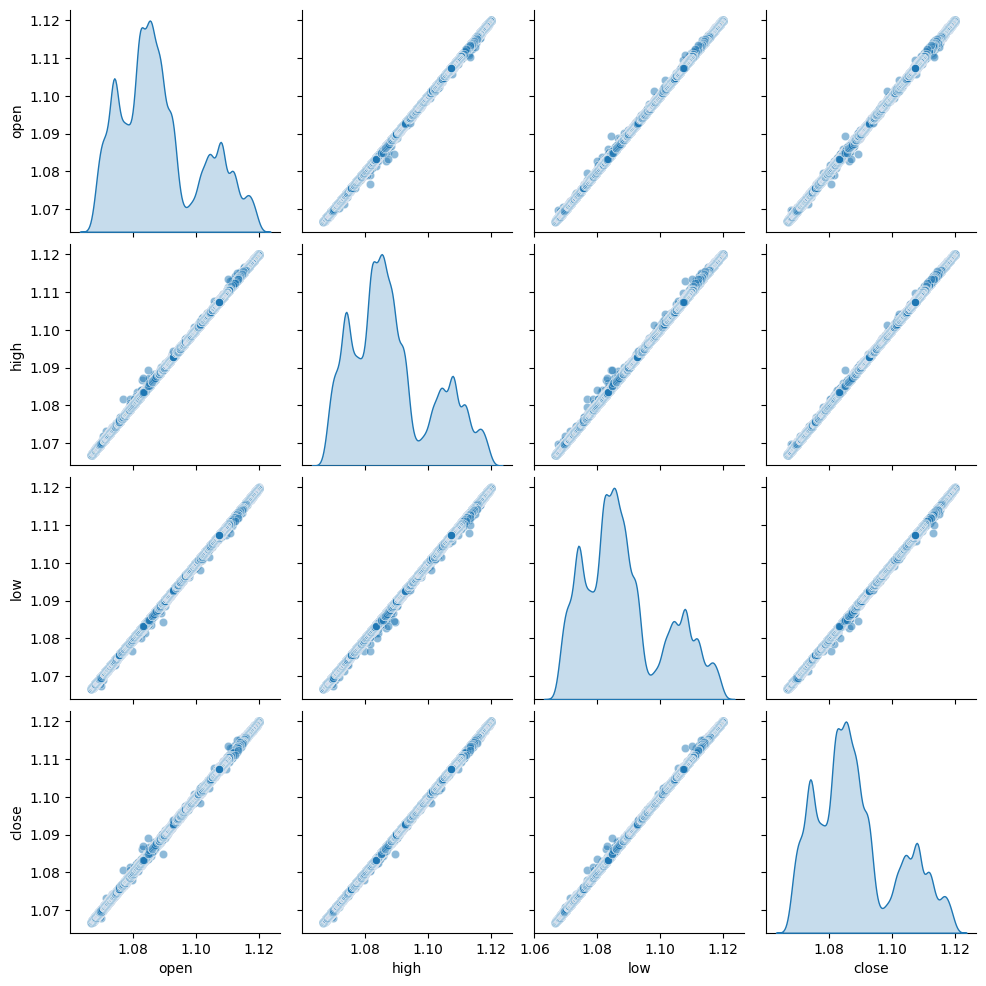

<Figure size 500x500 with 0 Axes>


---------- Line Plot for Close Price ----------


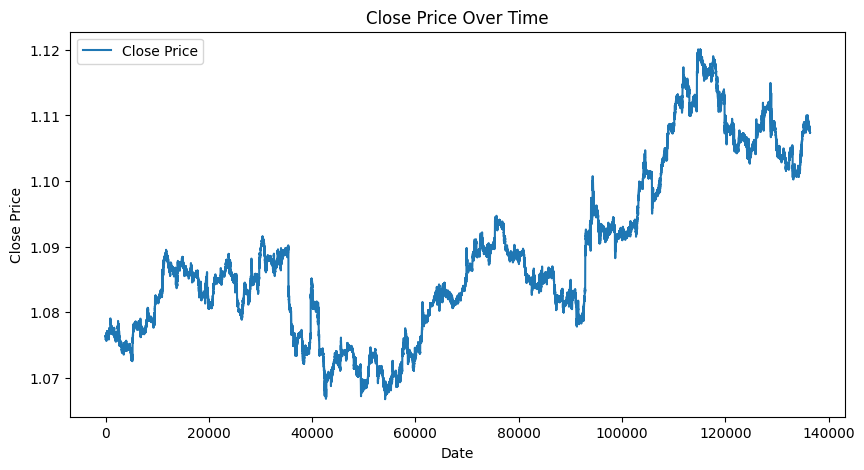


---------- Candlestick Chart ----------


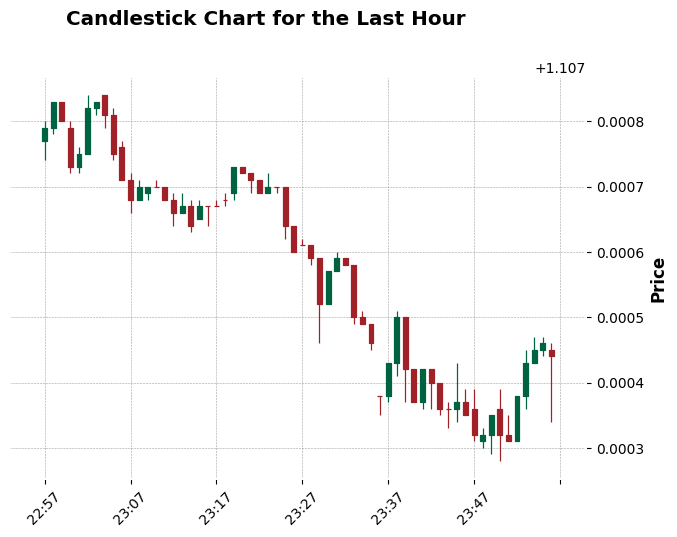


---------- Distribution of OHLC ----------


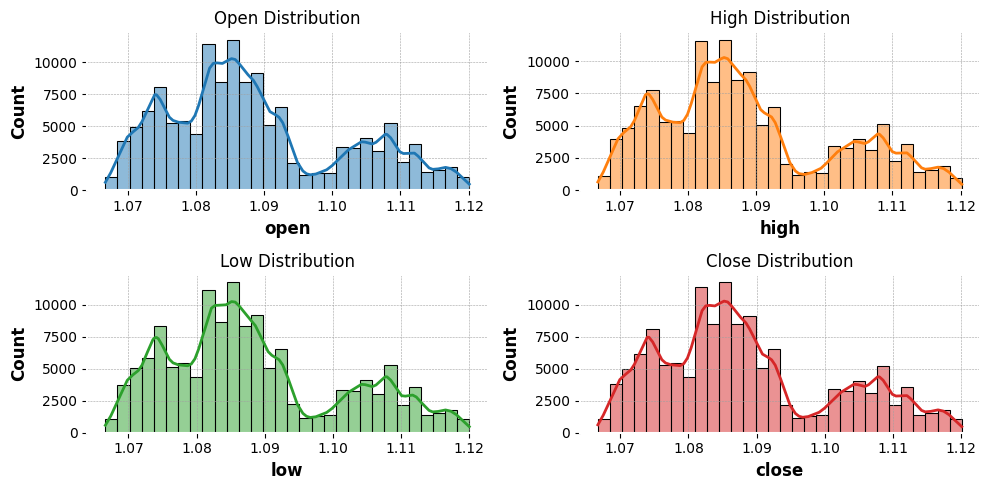


---------- Box Plot ----------


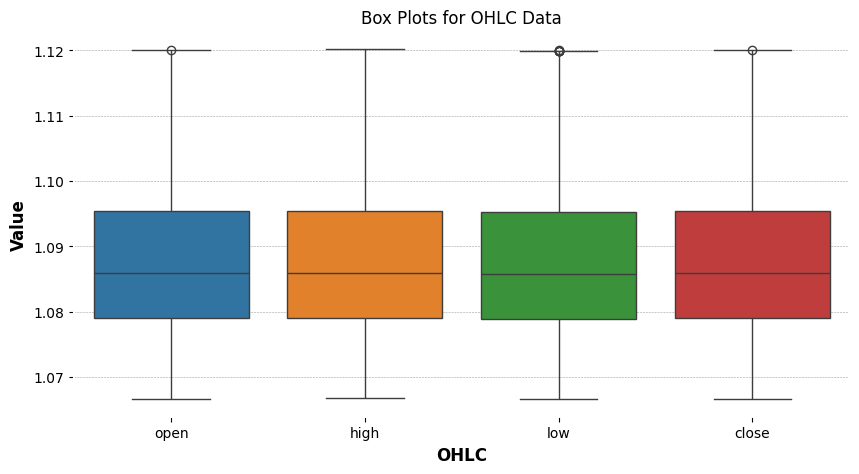

In [12]:
full_eda(data)

# __4. Technical Analysis__

## __4.1 Indicators__

In [13]:
data.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

#### __4.1.1 Simple Moving Average (SMA)__

In [14]:
data['SMA_10'] = ta.sma(data['close'], length=10)
data['SMA_20'] = ta.sma(data['close'], length=20)

#### __4.1.2 Exponential Moving Average (EMA)__

In [15]:
data['EMA_20'] = ta.ema(data['close'], length=20)

#### __4.1.3 Moving Average Convergence Divergence (MACD)__

In [16]:

macd = ta.macd(data['close'])

# Add the MACD, Signal, and Histogram to your DataFrame
data['MACD'] = macd['MACD_12_26_9']
data['MACD_Signal'] = macd['MACDs_12_26_9']
data['MACD_Histogram'] = macd['MACDh_12_26_9']

#### __4.1.4 Relative Strength Index (RSI)__

In [17]:
data['RSI_14'] = ta.rsi(data['close'], length=14)

In [18]:
data.head()

,open,high,low,close,SMA_10,SMA_20,EMA_20,MACD,MACD_Signal,MACD_Histogram,RSI_14
time,,,,,,,,,,,
2024-05-06 00:00:00,1.07661,1.07693,1.07589,1.07590,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-06 00:01:00,1.07609,1.07615,1.07594,1.07611,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-06 00:02:00,1.07616,1.07616,1.07616,1.07616,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-06 00:03:00,1.07604,1.07631,1.07604,1.07631,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-06 00:04:00,1.07631,1.07631,1.07631,1.07631,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### __4.2 Calculating Slope__

I calculate the slope of the indicators over a rolling window using linear regression. The slope tells us the direction ( or indicates the rate of change in the values over time) and strength of the trend over a specified number of periods.

The calculated slope reflects the trend's direction and magnitude:

- Positive Slope: Indicates an upward trend in the data.
- Negative Slope: Indicates a downward trend.
- Slope Magnitude: The greater the magnitude, the steeper the trend.

In [19]:
def get_slope(array):
    '''
    Parameters
    array: A sequence of numerical values (e.g., SMA values) over which the slope will be calculated. The function expects this to be a NumPy array.
    Returns
    slope: The slope of the linear regression line fitted to the input array.
    '''
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    return slope

In [20]:
back_roll_by = 4

indicator_columns = ['SMA_10','SMA_20', 'EMA_20', 'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Histogram']  


for column in indicator_columns:
    slope_column_name = f'slope_{column}'
    data[slope_column_name] = data[column].rolling(window=back_roll_by).apply(get_slope, raw=True)


In [21]:
# back_roll_by = 4

# data['slope_SMA_10'] = data['SMA_10'].rolling(window=back_roll_by).apply(get_slope, raw= True)

In [22]:
data.sample(5)

,open,high,low,close,SMA_10,SMA_20,EMA_20,MACD,MACD_Signal,MACD_Histogram,RSI_14,slope_SMA_10,slope_SMA_20,slope_EMA_20,slope_RSI_14,slope_MACD,slope_MACD_Signal,slope_MACD_Histogram
time,,,,,,,,,,,,,,,,,,
2024-07-16 00:26:00,1.08948,1.08952,1.08947,1.08950,1.089473,1.089445,1.089452,0.000005,-0.000008,0.000013,52.893963,0.000004,0.000008,0.000004,0.644055,0.000003,0.000003,1.535977e-07
2024-06-13 08:34:00,1.08038,1.08043,1.08038,1.08043,1.080364,1.080254,1.080310,0.000030,0.000005,0.000025,65.290638,0.000024,0.000007,0.000010,3.268409,0.000005,0.000006,-8.724537e-07
2024-07-10 22:57:00,1.08284,1.08290,1.08284,1.08290,1.082866,1.082768,1.082784,0.000081,0.000075,0.000006,67.308374,0.000015,0.000015,0.000010,-3.496215,-0.000002,0.000002,-4.385075e-06
2024-05-22 01:05:00,1.08561,1.08569,1.08561,1.08565,1.085588,1.085563,1.085573,0.000024,0.000013,0.000011,63.529006,0.000015,0.000002,0.000006,0.931012,0.000003,0.000002,3.072293e-07
2024-08-26 15:47:00,1.11634,1.11646,1.11629,1.11646,1.116207,1.116208,1.116255,-0.000063,-0.000094,0.000031,56.370865,0.000019,-0.000017,0.000005,7.085845,0.000017,0.000002,1.484959e-05


# __5. Preparing Data__

### __5.1 Scaling__

In [23]:
# numerical_features = ['open', 'high', 'low', 'close'] 


# data[numerical_features] = data[numerical_features]

# scaler = MinMaxScaler()
# data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [24]:
# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(data[['close']])
# data['close'] = scaled_data

# scaler = StandardScaler()

# data['close'] = scaler.fit_transform(data[['close']]) 

In [25]:
data

,open,high,low,close,SMA_10,SMA_20,EMA_20,MACD,MACD_Signal,MACD_Histogram,RSI_14,slope_SMA_10,slope_SMA_20,slope_EMA_20,slope_RSI_14,slope_MACD,slope_MACD_Signal,slope_MACD_Histogram
time,,,,,,,,,,,,,,,,,,
2024-05-06 00:00:00,1.07661,1.07693,1.07589,1.07590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-06 00:01:00,1.07609,1.07615,1.07594,1.07611,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-06 00:02:00,1.07616,1.07616,1.07616,1.07616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-06 00:03:00,1.07604,1.07631,1.07604,1.07631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-05-06 00:04:00,1.07631,1.07631,1.07631,1.07631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-13 23:52:00,1.10731,1.10738,1.10731,1.10738,1.107344,1.107390,1.107403,-0.000068,-0.000074,0.000006,43.252856,-0.000006,-1.235000e-05,-0.000008,2.051891,0.000003,5.679478e-07,0.000002
2024-09-13 23:53:00,1.10738,1.10745,1.10736,1.10743,1.107351,1.107387,1.107405,-0.000057,-0.000071,0.000013,49.319582,-0.000002,-9.250000e-06,-0.000003,5.756796,0.000006,1.677527e-06,0.000004
2024-09-13 23:54:00,1.10743,1.10747,1.10743,1.10745,1.107360,1.107385,1.107409,-0.000047,-0.000066,0.000019,51.550798,0.000005,-5.000000e-06,0.000002,6.233553,0.000009,3.202037e-06,0.000006


### __5.2 Creating training data__

#### __5.2.1 Preparing Lagged Data__

- __`df`:__ This is a DataFrame containing the original data.
  
- __`lag_steps:`__ This is an integer representing the number of time steps to lag the time unit by. It determines how many previous values of the target variable ('close') to include in the lagged DataFrame.
  
- __`lagged_df:`__ This is a new DataFrame that will store the lagged data.
  
- __`pd.DataFrame(index=df.index)`:__ This creates a new DataFrame with the same index as the original DataFrame df. The index represents the date and time of each data point.
  
- __`lagged_df['DateTime'] = df.index:`__ This creates a new column in the lagged_df DataFrame called 'DateTime', and it copies the index of the original DataFrame df. This column will store the date and time information.
  
- __`lagged_df['ActualValue'] = df['close']:`__ This creates a new column in the lagged_df DataFrame called 'ActualValue', and it copies the values from the 'close' column of the original DataFrame df. This column will store the actual values of the target variable.
  
- __`Loop:`__ This loop iterates from 1 to lag_steps (inclusive). For each iteration:
    - __`lagged_df[f'PrevValue_{i}'] = df['close'].shift(i):`__ This creates a new column in the lagged_df DataFrame for each lagged value. The column name includes the prefix 'PrevValue_' followed by the lag index i. It shifts the values of the 'close' column of the original DataFrame df upwards by i time steps and stores them in the new column. This effectively creates lagged features for the target variable.
  
- __`return lagged_df.dropna():`__ This returns the lagged DataFrame after dropping any rows with missing values (NaN). Since creating lagged features involves shifting the data, the first few rows will contain NaN values where there is no data available for the lagged features.


In [26]:
go_back_by = 3

def create_lagged_dataframe(df, lag_steps=go_back_by, columns_to_lag=None):
    if columns_to_lag is None:
        columns_to_lag = df.columns  # By default, lag all columns

    lagged_df = pd.DataFrame(index=df.index)
    lagged_df['DateTime'] = df.index
    lagged_df['ActualValue'] = df['close']  # Keep 'ActualValue' for the close price

    # Creating lagged columns for each selected column
    for column in columns_to_lag:
        for i in range(1, lag_steps + 1):
            lagged_df[f'{column}_lag_{i}'] = df[column].shift(i)

    return lagged_df.dropna()

# Specify the columns you want to lag
columns_to_lag = ['close', 'SMA_10', 'SMA_20', 'EMA_20', 'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Histogram']

lagged_df = create_lagged_dataframe(data, lag_steps=go_back_by, columns_to_lag=columns_to_lag)


In [27]:
lagged_df.sample(3)


,DateTime,ActualValue,close_lag_1,close_lag_2,close_lag_3,SMA_10_lag_1,SMA_10_lag_2,SMA_10_lag_3,SMA_20_lag_1,SMA_20_lag_2,...,RSI_14_lag_3,MACD_lag_1,MACD_lag_2,MACD_lag_3,MACD_Signal_lag_1,MACD_Signal_lag_2,MACD_Signal_lag_3,MACD_Histogram_lag_1,MACD_Histogram_lag_2,MACD_Histogram_lag_3
time,,,,,,,,,,,,,,,,,,,,,
2024-07-01 17:35:00,2024-07-01 17:35:00,1.07389,1.07387,1.07419,1.07404,1.074252,1.074304,1.074324,1.074341,1.074391,...,29.903586,-2.739617e-04,-2.582092e-04,-2.669295e-04,-0.000266,-0.000265,-0.000266,-0.000008,0.000006,-8.376638e-07
2024-05-29 13:51:00,2024-05-29 13:51:00,1.08469,1.08457,1.08450,1.08439,1.084455,1.084436,1.084409,1.084330,1.084323,...,47.926886,1.539044e-06,-1.244093e-05,-2.297624e-05,-0.000039,-0.000049,-0.000059,0.000041,0.000037,3.567056e-05
2024-05-24 08:15:00,2024-05-24 08:15:00,1.08093,1.08092,1.08093,1.08093,1.080928,1.080930,1.080931,1.080930,1.080933,...,49.875042,-9.598458e-07,-1.018961e-07,-2.354009e-08,0.000001,0.000002,0.000002,-0.000002,-0.000002,-2.117621e-06


In [28]:
lagged_df.shape

(136360, 26)

In [29]:
lagged_df.columns


Index(['DateTime', 'ActualValue', 'close_lag_1', 'close_lag_2', 'close_lag_3',
       'SMA_10_lag_1', 'SMA_10_lag_2', 'SMA_10_lag_3', 'SMA_20_lag_1',
       'SMA_20_lag_2', 'SMA_20_lag_3', 'EMA_20_lag_1', 'EMA_20_lag_2',
       'EMA_20_lag_3', 'RSI_14_lag_1', 'RSI_14_lag_2', 'RSI_14_lag_3',
       'MACD_lag_1', 'MACD_lag_2', 'MACD_lag_3', 'MACD_Signal_lag_1',
       'MACD_Signal_lag_2', 'MACD_Signal_lag_3', 'MACD_Histogram_lag_1',
       'MACD_Histogram_lag_2', 'MACD_Histogram_lag_3'],
      dtype='object')

#### __5.2.2 Prepare LSTM Data__

- __`lagged_df:`__ This is a DataFrame containing the lagged data.

- __`dates:`__ This variable stores the date and time information from the lagged DataFrame.

- __`X:`__ This variable stores the input features for the LSTM model. It consists of all columns from the lagged DataFrame except 'DateTime' and 'ActualValue', converted to float32 data type.

- __`y:`__ This variable stores the target variable for the LSTM model, which is the 'ActualValue' column from the lagged DataFrame, converted to float32 data type.

- __`return:`__ The function returns three variables: dates, X, and y, containing the respective data.



In [30]:
def prepare_lstm_data(lagged_df):
    dates = lagged_df['DateTime']
    X = lagged_df.drop(columns=['DateTime', 'ActualValue']).astype(np.float32)
    y = lagged_df['ActualValue'].astype(np.float32)

    return dates, X.values, y.values


dates, X, y = prepare_lstm_data(lagged_df)
print("Dates:", dates.shape)
print("X shape:", X.shape)
print("y shape:", y.shape)


Dates: (136360,)
X shape: (136360, 24)
y shape: (136360,)


### __5.3 Spliting: Training, Validation, Testing Data__

#### __Split Data__

- __`dates:`__ This variable contains the date and time information.

- __`X:`__ This variable contains the input features for the model.

- __`y:`__ This variable contains the target variable for the model.

- __`x_train:`__ This variable contains the input features for the training set.

- __`y_train:`__ This variable contains the target variable for the training set.

- __`x_val:`__ This variable contains the input features for the validation set.

- __`y_val:`__ This variable contains the target variable for the validation set.

- __`x_test:`__ This variable contains the input features for the test set.

- __`y_test:`__ This variable contains the target variable for the test set.

- __`train_data:`__ This tuple contains the input features and target variable for the training set.

- __`val_data:`__ This tuple contains the input features and target variable for the validation set.

- __`test_data:`__ This tuple contains the input features and target variable for the test set.

- __`return:`__ The function returns three tuples: train_data, val_data, and test_data, each containing the respective input features and target variable for the corresponding set.



In [31]:
def split_data(dates, X, y):
    x_train, x_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

(train_data, val_data, test_data) = split_data(dates, X, y)
(x_train, y_train), (x_val, y_val), (x_test, y_test) = train_data, val_data, test_data


In [32]:
# OPTIONAL: Calculating the total number of instances
total_instances = len(x_train) + len(x_val) + len(x_test)

# Each set has
print("Training set:", len(x_train), "instances (", len(x_train) / total_instances * 100, "%)")
print("Validation set:", len(x_val), "instances (", len(x_val) / total_instances * 100, "%)")
print("Testing set:", len(x_test), "instances (", len(x_test) / total_instances * 100, "%)")


Training set: 95452 instances ( 70.0 %)
Validation set: 20454 instances ( 15.0 %)
Testing set: 20454 instances ( 15.0 %)



# __6. Training the model__

### __6.1 Weights and Biases__

In [33]:
!wandb login 92747ba767c68ec2ec63d2b44818eaeba8e973b9

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\tshol\.netrc


### __6.1.1 Defining the model__

In [34]:
run = wandb.init(
    project='first_keras_intergration',
    config={
        'learning_rate':0.001,
        'epochs' : 12,
        'batch_size': 64,
        'loss_function' : 'mean_squared_error',
        'architecture' : 'LSTM',
        }
    )

config =  wandb.config

tensorflow.keras.backend.clear_session()

#the actaul neural network
wb_model = Sequential([
    layers.Input((go_back_by,1)),

    layers.LSTM(10, return_sequences=True),
    layers.Dropout(0.2), 
    layers.LSTM(5), 
    layers.Dense(4, activation='relu', kernel_regularizer='l2'),  
    layers.Dropout(0.2),  
    layers.Dense(4, activation='relu', kernel_regularizer='l2'), 
     
    layers.Dense(1)
])

wb_model.summary()

# compile
wb_model.compile(
    loss = config.loss_function, 
    optimizer =  Adam(learning_rate=config.learning_rate),
    # metrics = ['mean_absolute_error']
    metrics=['mean_absolute_error', 'mse', RootMeanSquaredError()]
    )


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: masixole (masixoleboya). Use `wandb login --relogin` to force relogin


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 10)          │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5)              │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 849 (3.32 KB)

 Trainable params: 849 (3.32 KB)

 Non-trainable params: 0 (0.00 B)

### __6.1.2 Training the model__

In [35]:
wandb_history = wb_model.fit(
    x_train,y_train, 
    epochs = config.epochs,
    batch_size =  config.batch_size,
    validation_data = (x_test, y_test),
    callbacks = [WandbMetricsLogger()]
    )

Epoch 1/12
1492/1492 ━━━━━━━━━━━━━━━━━━━━ 1:20:49 3s/step - loss: 1.3524 - mean_absolute_error: 1.1232 - mse: 1.2621 - root_mean_squared_error: 1.123 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 1.3328 - mean_absolute_error: 1.1146 - mse: 1.2428 - root_mean_squared_error: 1.1148  ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - loss: 1.3157 - mean_absolute_error: 1.1070 - mse: 1.2261 - root_mean_squared_error: 1.10 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 1.3034 - mean_absolute_error: 1.1016 - mse: 1.2141 - root_mean_squared_error: 1.10 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 1.2940 - mean_absolute_error: 1.0975 - mse: 1.2051 - root_mean_squared_error: 1.09 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 1.2862 - mean_absolute_error: 1.0941 - mse: 1.1977 - root_mean_squared_error: 1.09 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 1.2784 - mean_absolute_error: 1.0907 - mse: 1.1903 - root_mean_squared_error: 1.09 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 1.2714 - mean_absolute_error: 1.0877 - mse: 1.1837 - ro

In [36]:
wb_model.save("LSTM_model_just_trial-1.0.keras")

# __7. Hyperparameter Tuning__

In [ ]:
def objective(trial):
    num_layers = trial.suggest_int('num_layers', 1, 5)
    layer_units = [trial.suggest_int(f'layer_units_{i}', 4, 64) for i in range(num_layers)]
    activation = trial.suggest_categorical('activation', ['relu', 'tanh', 'sigmoid'])
    epochs = trial.suggest_int('epochs', 2, 10)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    
    # Initialize WandB run
    # wandb.init(project='first_keras_intergration', config={
    #     'learning_rate': learning_rate,
    #     'epochs': epochs,
    #     'batch_size': 64,
    #     'loss_function': 'mean_squared_error',
    #     'architecture': 'LSTM',
    #     'dropout_rate': dropout_rate
    # })
    
    config = {
        'learning_rate': learning_rate,
        'epochs': epochs,
        'batch_size': 64,
        'loss_function': 'mean_squared_error',
        'architecture': 'LSTM',
        'dropout_rate': dropout_rate
    }

    # Clear previous session
    tensorflow.keras.backend.clear_session()

    # Create the Keras model
    wb_model = Sequential([
        layers.Input((go_back_by, 1)),
        layers.LSTM(layer_units[0], return_sequences=True),
        layers.Dropout(dropout_rate)
    ])

    for units in layer_units[1:-1]:
        wb_model.add(layers.LSTM(units, return_sequences=True))
        wb_model.add(layers.Dropout(dropout_rate))
    
    wb_model.add(layers.LSTM(layer_units[-1], return_sequences=False))
    wb_model.add(layers.Dropout(dropout_rate))
    wb_model.add(layers.Dense(4, activation=activation, kernel_regularizer='l2'))
    wb_model.add(layers.Dropout(dropout_rate))
    wb_model.add(layers.Dense(4, activation=activation, kernel_regularizer='l2'))
    wb_model.add(layers.Dense(1))

    # Compile the model
    wb_model.compile(
        loss=config['loss_function'],
        optimizer=Adam(learning_rate=config['learning_rate']),
        metrics=['mean_absolute_error', 'mean_squared_error', RootMeanSquaredError()]
    )
    
    # Train the model
    wandb_history = wb_model.fit(
        x_train, y_train,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_data=(x_test, y_test)
        # No WandB callbacks here
    )
    
    # Evaluate the model
    val_loss = wandb_history.history['val_loss'][-1]
    return val_loss


study = optuna.create_study(direction='minimize', study_name='keras_lstm_opt_1')
study.optimize(objective, n_trials=5)


In [48]:
best_trial = study.best_trial

print("Best hyperparameters: ", best_trial.params)


Best hyperparameters:  {'num_layers': 5, 'layer_units_0': 37, 'layer_units_1': 32, 'layer_units_2': 34, 'layer_units_3': 35, 'layer_units_4': 21, 'activation': 'tanh', 'epochs': 7, 'dropout_rate': 0.3688289947501153, 'learning_rate': 0.01128085357233952}


In [49]:
best_trial = study.best_trial

# Extract the best hyperparameters
best_params = best_trial.params

# Print the best hyperparameters
print("Best hyperparameters: ", best_params)

# # Save the best hyperparameters to a .txt file
# with open("best_hyperparameters.txt", "w") as file:
#     file.write("Best hyperparameters:\n")
#     for key, value in best_params.items():
#         file.write(f"{key}: {value}\n")

print("Best hyperparameters:\n")
for key, value in best_params.items():
    print(f"{key}: {value}\n")


Best hyperparameters:  {'num_layers': 5, 'layer_units_0': 37, 'layer_units_1': 32, 'layer_units_2': 34, 'layer_units_3': 35, 'layer_units_4': 21, 'activation': 'tanh', 'epochs': 7, 'dropout_rate': 0.3688289947501153, 'learning_rate': 0.01128085357233952}


In [57]:
import tensorflow.keras.backend as K
K.clear_session()


In [58]:
# Extract the best hyperparameters
best_params = best_trial.params

# Dynamically extract the layer units
layer_units = [best_params[f'layer_units_{i}'] for i in range(best_params['num_layers'])]

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
import wandb

# Initialize the WandB run using best hyperparameters
run = wandb.init(
    project='first_keras_integration',
    config={
        'learning_rate': best_params['learning_rate'],
        'epochs': best_params['epochs'],
        'batch_size': 64,  # You can adjust if needed
        'loss_function': 'mean_squared_error',
        'architecture': 'LSTM',
        'dropout_rate': best_params['dropout_rate']
    }
)

# Use WandB config
config = wandb.config

# Clear any previous session
tf.keras.backend.clear_session()

# Dynamically build the LSTM model using the best hyperparameters
wb_model = Sequential()

# Add input layer
wb_model.add(layers.Input((go_back_by, 1)))

# Add LSTM layers and Dropout layers dynamically based on best_params
for i in range(best_params['num_layers']):
    units = best_params[f'layer_units_{i}']
    return_sequences = i < best_params['num_layers'] - 1  # True for all but the last LSTM layer
    wb_model.add(layers.LSTM(units, return_sequences=return_sequences))
    wb_model.add(layers.Dropout(config.dropout_rate))

# Add Dense layers as per architecture
wb_model.add(layers.Dense(4, activation=best_params['activation'], kernel_regularizer='l2'))
wb_model.add(layers.Dropout(config.dropout_rate))
wb_model.add(layers.Dense(4, activation=best_params['activation'], kernel_regularizer='l2'))

# Output layer (single output for regression)
wb_model.add(layers.Dense(1))

# Print model summary (optional)
wb_model.summary()

# Compile the model
wb_model.compile(
    loss=config.loss_function,
    optimizer=Adam(learning_rate=config.learning_rate),
    metrics=['mean_absolute_error', 'mean_squared_error', RootMeanSquaredError()]
)

# Train the model with WandB logging
wb_model.fit(
    x_train, y_train,
    epochs=config.epochs,
    batch_size=config.batch_size,
    validation_data=(x_test, y_test),
    callbacks=[wandb.keras.WandbCallback()]  # Ensure WandB logs the training process
)

# Finish the WandB run
run.finish()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 37)          │         5,772 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 37)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 32)          │         8,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 3, 34)          │         9,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 34)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 3, 35)          │         9,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 35)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 21)             │         4,788 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,545 (150.57 KB)

 Trainable params: 38,545 (150.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7


AttributeError: 'Node' object has no attribute 'inbound_layers'

# __8. Model Evaluation__

In [ ]:

loss, mae = wb_model.evaluate(x_test, y_test, verbose=0)

#Evaluating on the test data
predictions = wb_model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
r2 = r2_score(y_test, predictions)

print('\nTest Loss:', loss)
print('\nMean Absolute Error:', mae)
print('\nRoot Mean Squared Error:', rmse)
print('\nR-squared:', r2)

42874/42874 ━━━━━━━━━━━━━━━━━━━━ 140s 3ms/step

Test Loss: 0.0009474472026340663

Mean Absolute Error: 0.02057075873017311

Root Mean Squared Error: 0.02684274

R-squared: 0.9699871713199525


In [ ]:
# plt.figure(figsize=(10, 6))
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()
